In [152]:
import os
from collections import Counter
from pathlib import Path
import re

import pandas as pd
import numpy as np

import seaborn as sns
from sklearn.impute import SimpleImputer
import mgitools.os_helpers as os_helpers
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import seaborn as sns


In [26]:
# !pip install git+https://github.com/estorrs/mgitools
# !pip install sklearn
# !conda install -y -c bioconda scanpy

In [126]:
results_dir = '/data/results/09232020_data_prep'
Path(results_dir).mkdir(exist_ok=True, parents=True)

###### name conversion

In [6]:
CANCER_TYPE_MAP = {
    'CPTAC2_BRCA_prospective': 'BRCA_prospective',
    'TCGA_BRCA_retrospective': 'BRCA_retrospective',
    'BR': 'BRCA_prospective',
    'BRCA': 'BRCA_prospective',
    'CPTAC2_CRC_prospective': 'CRC_prospective',
    'CO': 'CRC_prospective',
    'COADREAD': 'CRC_prospective',
    'CPTAC2_OV_prospective': 'OV_prospective',
    'TCGA_OV_retrospective': 'OV_retrospective',
    'OV': 'OV_prospective',
    'CPTAC3_CCRCC_discovery': 'CCRCC',
    'KIRC': 'CCRCC',
    'CPTAC3_GBM_discovery': 'GBM',
    'CPTAC3_HNSCC_discovery': 'HNSCC',
    'HNSC': 'HNSCC',
    'CPTAC3_LSCC_discovery': 'LSCC',
    'LUSC': 'LSCC',
    'CPTAC3_LUAD_discovery': 'LUAD',
    'CPTAC3_UCEC_discovery': 'UCEC'
}

# data processing

### driver genes

In [7]:
genes = pd.read_csv('/data/driver_genes/bailey_smg_table.tsv', sep='\t')
genes

,Gene,Cancer
0,ABL1,PANCAN
1,ACVR1,UCEC
2,ACVR1B,PANCAN
3,ACVR2A,COADREAD
4,ACVR2A,LIHC
...,...,...
734,ZMYM3,PRAD
735,ZNF133,OV
736,ZNF750,PANCAN
737,ZNF750,ESCA


In [8]:
drivers = pd.read_csv('/data/driver_genes/199_driver_list.txt', sep='\t')
drivers

,Gene,Tumor suppressor or oncogene prediction (by 20/20+)
0,PHF6,possible tsg
1,ABL1,NaN
2,ALK,NaN
3,AR,NaN
4,ARAF,NaN
...,...,...
183,KMT2A,tsg
184,KMT2B,tsg
185,MAX,oncogene
186,MED12,oncogene


In [9]:
cancer_to_driver_genes = {CANCER_TYPE_MAP.get(c, c):genes[genes['Cancer']==c].set_index('Gene')
                          for c in sorted(set(genes['Cancer']))}
cancer_to_driver_genes.keys()

dict_keys(['ACC', 'BLCA', 'BRCA_prospective', 'CESC', 'CHOL', 'CRC_prospective', 'DLBC', 'ESCA', 'GBM', 'HNSCC', 'KICH', 'CCRCC', 'KIRP', 'LAML', 'LGG', 'LIHC', 'LUAD', 'LSCC', 'MESO', 'OV_prospective', 'PAAD', 'PANCAN', 'PCPG', 'PRAD', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM'])

### somatic mutations

In [10]:
mutation_dir = '/data/somtatic_mutations/'
mutation_fps = sorted(os_helpers.listfiles(mutation_dir, regex=r'.maf$'))
mutation_fps

['/data/somtatic_mutations/BR.maf',
 '/data/somtatic_mutations/CCRCC.maf',
 '/data/somtatic_mutations/CO.maf',
 '/data/somtatic_mutations/GBM.maf',
 '/data/somtatic_mutations/HNSCC.maf',
 '/data/somtatic_mutations/LSCC.maf',
 '/data/somtatic_mutations/LUAD.maf',
 '/data/somtatic_mutations/OV.maf',
 '/data/somtatic_mutations/UCEC.maf']

In [11]:
cancer_to_maf = {}
for fp in mutation_fps:
    cancer = fp.split('/')[-1].split('.')[0]
    mutation_df = pd.read_csv(fp, sep='\t')
    mutation_df['sample_id'] = [x.split('_')[0] for x in mutation_df['Tumor_Sample_Barcode']]
    mutation_df = mutation_df[mutation_df['Variant_Classification']!='Silent']
    cancer_to_maf[CANCER_TYPE_MAP.get(cancer, cancer)] = mutation_df
cancer_to_maf.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (88) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


dict_keys(['BRCA_prospective', 'CCRCC', 'CRC_prospective', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'UCEC'])

### gene expression

In [12]:
expression_dir = '/data/expression'
expression_fps = sorted(os_helpers.listfiles(expression_dir, regex=r'fpkm.tsv$'))
expression_fps

['/data/expression/AML_fpkm.tsv',
 '/data/expression/BR_fpkm.tsv',
 '/data/expression/CCRCC_fpkm.tsv',
 '/data/expression/CM_fpkm.tsv',
 '/data/expression/CO_fpkm.tsv',
 '/data/expression/EGAD-PDAC_fpkm.tsv',
 '/data/expression/GBM_fpkm.tsv',
 '/data/expression/HNSCC_fpkm.tsv',
 '/data/expression/LSCC_fpkm.tsv',
 '/data/expression/LUAD_fpkm.tsv',
 '/data/expression/OV_fpkm.tsv',
 '/data/expression/PDA_fpkm.tsv',
 '/data/expression/SAR_fpkm.tsv',
 '/data/expression/UCEC_fpkm.tsv',
 '/data/expression/eocg_fpkm.tsv',
 '/data/expression/hipsci_managed_fpkm.tsv',
 '/data/expression/hipsci_public_fpkm.tsv']

In [13]:
cancer_type_to_expression = {}
for fp in expression_fps:
    cancer = fp.split('/')[-1].replace('_fpkm.tsv', '')
    
    cancer_type_to_expression[CANCER_TYPE_MAP.get(cancer, cancer)] = pd.read_csv(fp, sep='\t', index_col='gene')
cancer_type_to_expression.keys()

dict_keys(['AML', 'BRCA_prospective', 'CCRCC', 'CM', 'CRC_prospective', 'EGAD-PDAC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV_prospective', 'PDA', 'SAR', 'UCEC', 'eocg', 'hipsci_managed', 'hipsci_public'])

### protein

In [71]:
def process_gct(fp):
    f = open(fp)
    f.readline()
    _, n_samples, n_feature_metadata, n_sample_metadata = [int(x) for x in f.readline().strip().split('\t')]
    df = pd.read_csv(f, sep='\t')
    df.columns = [c[1:] if c[0]=='X' else c for c in df.columns]

    ## do some renaming and split metadata into different table
    ids = df['id'].to_list()[:n_sample_metadata - 1]
    metadata = df.iloc[:n_sample_metadata - 1, -n_samples:].copy()
    metadata.index = ids
    metadata = metadata.transpose()


    df = df.iloc[n_sample_metadata:, :]
    #     print(df.shape)
    df = df.set_index('id')
    df.index.name = 'site_id'
    
    ## pull out samples we have metadata for
    data = df[[c for c in metadata.index if c in df.columns]]
    
    ## pull out variable data
    var = df[[c for c in df.columns if c not in metadata.index]]
    
    adata = anndata.AnnData(X=data.values.transpose(), obs=metadata, var=var)
    adata.obs.index.name = 'sample_id'
    
    ## add gene name in
    adata.var['gene'] = [x.split(':')[0] for x in adata.var.index]
    
    return adata

In [150]:
def update_identifiers(adata, cancer):
    if cancer in ['LUAD', 'LSCC']:
        adata.obs.index = [x + '.T' if x[-2:]!='.N' else x for x in adata.obs.index]
        
#     if cancer in ['UCEC']:
#         adata.obs.index = [x + '.T' if y == 'Tumor' else x + '.N'
#                           for x, y in zip(adata.obs['case_id'], adata.obs['sample_type'])]
        
    if cancer in ['CCRCC', 'UCEC']:
        adata.obs.index = [x + '.T' if y == 'Primary Tumor' else x + '.N'
                          for x, y in zip(adata.obs['case_id'], adata.obs['sample_type'])]
    
    if cancer in ['GBM', 'BRCA_prospective']:
        adata.obs.index = [x + '.T' for x in adata.obs.index]
        
    if cancer in ['OV_prospective']:
        adata.obs.index = [re.sub(r'^C(.*)$', r'\1', x) + '.T' if y == 'Primary Tumor' else re.sub(r'^C(.*)$', r'\1', x) + '.N'
                          for x, y in zip(adata.obs.index, adata.obs['sample_type'])]
        
    if cancer in ['CRC_prospective', 'HNSCC']:
        adata.obs.index = [x.replace('-', '.') for x in adata.obs.index]
        
    adata.obs['sample_type'] = ['tumor' if x[-2:]=='.T' else 'normal' for x in adata.obs.index]
    return adata


In [95]:
def impute_highly_missing(adata, threshold=.75):
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    mask = [True if x >= threshold else False for x in frac_present]
    new_adata = adata[:, mask].copy()

    new_adata = anndata.AnnData(X=SimpleImputer(strategy='median').fit_transform(new_adata.X),
                               obs=new_adata.obs, var=new_adata.var)

    
    return new_adata

In [110]:
def aggregate_to_gene_level(adata):
    df = pd.DataFrame(data=adata.X.transpose(), columns=adata.obs.index)
    df['gene'] = adata.var['gene'].to_list()
    df = df.groupby('gene').mean()
    
    new_adata = anndata.AnnData(X=df.values.transpose(), obs=adata.obs,)
    new_adata.var.index = df.index
    
    return new_adata

#### acetyl

In [73]:
fps = sorted(os_helpers.listfiles('/data/v2.0/', regex=r'acetylome.*.gct'))
fps

['/data/v2.0/CPTAC2_BRCA_prospective/CPTAC2_BRCA_prospective_broad_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_GBM_discovery/CPTAC3_GBM_discovery_pnnl_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_LSCC_discovery/CPTAC3_LSCC_discovery_broad_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_LUAD_discovery/CPTAC3_LUAD_discovery_broad_acetylome.v2.0.gct',
 '/data/v2.0/CPTAC3_UCEC_discovery/CPTAC3_UCEC_discovery_pnnl_acetylome.v2.0.gct']

In [121]:
cancer_to_adata = {}
for fp in fps:
    cancer = fp.split('/')[3]
    cancer = CANCER_TYPE_MAP.get(cancer, cancer)
    
    cancer_to_adata[cancer] = process_gct(fp)
    
cancer_to_adata.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (6,7,11,13,14,15,16,17,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (6,7,11,13,14,15,16,17,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93

dict_keys(['BRCA_prospective', 'GBM', 'LSCC', 'LUAD', 'UCEC'])

In [122]:
cancer_to_adata = {c:update_identifiers(adata, c) for c, adata in cancer_to_adata.items()}

In [123]:
cancer_to_gene_level = {c:aggregate_to_gene_level(adata) for c, adata in cancer_to_adata.items()}

/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

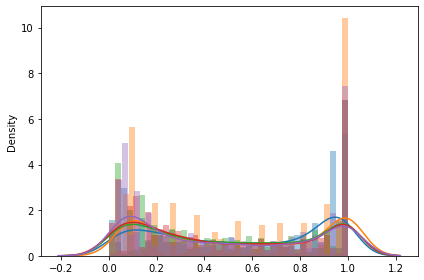

In [128]:
for cancer, adata in cancer_to_gene_level.items():
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    sns.distplot(frac_present, bins=40,)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'fraction_of_genes_missing_acetyl.pdf'))

In [129]:
cancer_to_gene_level = {c:impute_highly_missing(adata, threshold=.9) for c, adata in cancer_to_gene_level.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categori

In [130]:
for cancer, adata in cancer_to_gene_level.items():
    adata.write_h5ad(os.path.join(results_dir, f'acetyl_processed_{cancer}.h5ad'))

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical


##### phospho

In [131]:
fps = sorted(os_helpers.listfiles('/data/v2.0/', regex=r'phosph.*.gct'))
fps

['/data/v2.0/CPTAC2_BRCA_prospective/CPTAC2_BRCA_prospective_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC2_CRC_prospective/CPTAC2_CRC_prospective_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC2_OV_prospective/CPTAC2_OV_prospective_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_CCRCC_discovery/CPTAC3_CCRCC_discovery_umich_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_GBM_discovery/CPTAC3_GBM_discovery_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_HNSCC_discovery/CPTAC3_HNSCC_discovery_umich_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LSCC_discovery/CPTAC3_LSCC_discovery_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LUAD_discovery/CPTAC3_LUAD_discovery_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/CPTAC3_UCEC_discovery/CPTAC3_UCEC_discovery_pnnl_phosphoproteome.v2.0.gct',
 '/data/v2.0/TCGA_BRCA_retrospective/TCGA_BRCA_retrospective_broad_phosphoproteome.v2.0.gct',
 '/data/v2.0/TCGA_OV_retrospective/TCGA_OV_retrospective_pnnl_phosphoproteome.v2.0.gct']

In [153]:
cancer_to_adata = {}
for fp in fps:
    cancer = fp.split('/')[3]
    cancer = CANCER_TYPE_MAP.get(cancer, cancer)
    
    cancer_to_adata[cancer] = process_gct(fp)
    
cancer_to_adata.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (6,7,11,13,14,15,16,17,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (5,6,7,8,13,15,16,17,18,19,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,9

dict_keys(['BRCA_prospective', 'CRC_prospective', 'OV_prospective', 'CCRCC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'UCEC', 'BRCA_retrospective', 'OV_retrospective'])

In [154]:
cancer_to_adata = {c:update_identifiers(adata, c) for c, adata in cancer_to_adata.items()}

In [155]:
cancer_to_gene_level = {c:aggregate_to_gene_level(adata) for c, adata in cancer_to_adata.items()}

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

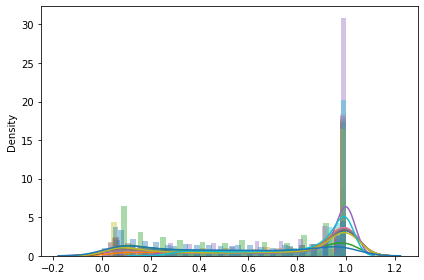

In [156]:
for cancer, adata in cancer_to_gene_level.items():
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    sns.distplot(frac_present, bins=40,)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'fraction_of_genes_missing_phospho.pdf'))

In [157]:
cancer_to_gene_level = {c:impute_highly_missing(adata, threshold=.9) for c, adata in cancer_to_gene_level.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categori

In [158]:
for cancer, adata in cancer_to_gene_level.items():
    adata.write_h5ad(os.path.join(results_dir, f'phospho_processed_{cancer}.h5ad'))

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_experiment' as categorical
... storing 'tmt_channel' as categorical
... storing 'sample_type' as categorical
... storing 'case_id' as categorical
... storing 'sample_type' as categorical
... storing 

##### proteome

In [160]:
fps = sorted(os_helpers.listfiles('/data/v2.0/', regex=r'_proteome.*.gct'))
fps

['/data/v2.0/CPTAC2_BRCA_prospective/CPTAC2_BRCA_prospective_broad_proteome.v2.0.gct',
 '/data/v2.0/CPTAC2_CRC_prospective/CPTAC2_CRC_prospective_pnnl_proteome.v2.0.gct',
 '/data/v2.0/CPTAC2_OV_prospective/CPTAC2_OV_prospective_pnnl_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_CCRCC_discovery/CPTAC3_CCRCC_discovery_umich_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_GBM_discovery/CPTAC3_GBM_discovery_pnnl_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_HNSCC_discovery/CPTAC3_HNSCC_discovery_umich_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LSCC_discovery/CPTAC3_LSCC_discovery_broad_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_LUAD_discovery/CPTAC3_LUAD_discovery_broad_proteome.v2.0.gct',
 '/data/v2.0/CPTAC3_UCEC_discovery/CPTAC3_UCEC_discovery_pnnl_proteome.v2.0.gct',
 '/data/v2.0/TCGA_BRCA_retrospective/TCGA_BRCA_retrospective_broad_proteome.v2.0.gct',
 '/data/v2.0/TCGA_OV_retrospective/TCGA_OV_retrospective_pnnl_proteome.v2.0.gct']

In [161]:
cancer_to_adata = {}
for fp in fps:
    cancer = fp.split('/')[3]
    cancer = CANCER_TYPE_MAP.get(cancer, cancer)
    
    cancer_to_adata[cancer] = process_gct(fp)
    
cancer_to_adata.keys()

/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (2,3,4,5,6,7,8,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/miniconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3337: DtypeWarning: Columns (2,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,

dict_keys(['BRCA_prospective', 'CRC_prospective', 'OV_prospective', 'CCRCC', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'UCEC', 'BRCA_retrospective', 'OV_retrospective'])

In [162]:
cancer_to_adata = {c:update_identifiers(adata, c) for c, adata in cancer_to_adata.items()}

In [166]:
for adata in cancer_to_adata.values(): adata.var.index.name = 'gene'
cancer_to_adata['CCRCC'].var

,num_psm,refseq_prot_ids,hgnc_id,entrez_gene_id,ensembl_gene_id,gene
gene,,,,,,
A1BG,1984,NP_570602.2,HGNC:5,1,ENSG00000121410,A1BG
A1CF,533,NP_620310.1,HGNC:24086,29974,ENSG00000148584,A1CF
A2M,8181,NP_000005.2,HGNC:7,2,ENSG00000175899,A2M
A4GALT,1,NP_001304967.1,HGNC:18149,53947,ENSG00000128274,A4GALT
AAAS,297,NP_056480.1,HGNC:13666,8086,ENSG00000094914,AAAS
...,...,...,...,...,...,...
ZXDC,26,NP_001035743.1,HGNC:28160,79364,ENSG00000070476,ZXDC
ZYG11B,167,NP_078922.1,HGNC:25820,79699,ENSG00000162378,ZYG11B
ZYX,1132,NP_001010972.1,HGNC:13200,7791,ENSG00000159840,ZYX


/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/miniconda/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

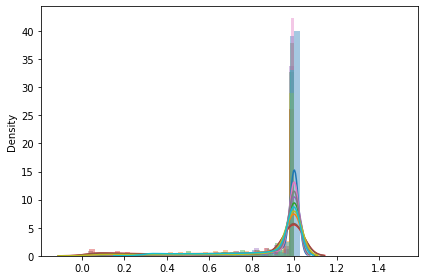

In [168]:
for cancer, adata in cancer_to_adata.items():
    counts = np.count_nonzero(~np.isnan(adata.X), axis=0)
    frac_present = counts / adata.shape[0]
    sns.distplot(frac_present, bins=40,)
plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'fraction_of_genes_missing_proteome.pdf'))

In [169]:
cancer_to_gene_level = {c:impute_highly_missing(adata, threshold=.9) for c, adata in cancer_to_gene_level.items()}

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categori

In [170]:
for cancer, adata in cancer_to_gene_level.items():
    adata.write_h5ad(os.path.join(results_dir, f'proteome_processed_{cancer}.h5ad'))

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


### dataset construction

In [184]:
adata

AnnData object with n_obs × n_vars = 69 × 413
    obs: 'case_id', 'sample_type'

In [185]:
adata.obs

,case_id,sample_type
sample_id,,
TCGA-13-1484,TCGA-13-1484,normal
TCGA-13-1489,TCGA-13-1489,normal
TCGA-13-1494,TCGA-13-1494,normal
TCGA-13-1499,TCGA-13-1499,normal
TCGA-13-2071,TCGA-13-2071,normal
...,...,...
TCGA-61-1919,TCGA-61-1919,normal
TCGA-61-1995,TCGA-61-1995,normal
TCGA-61-2008,TCGA-61-2008,normal


In [186]:
adata.var

""
gene
AAAS
ABCC1
ABCC4
ACAP2
ACTA1
...
ZNF281
ZNF532
ZNF768


In [189]:
adata[0, 'AAAS'].X[0, 0]

-0.0951

In [210]:
def transform_gene_level_adata(adata, dtype):
    cases = adata.obs['case_id'].to_list()
    case_to_gene_to_vals = {}
#         mini = adata[:, [gene]]
    
    for case in cases:
        mini = adata[adata.obs['case_id']==case]
#         print(mini.shape)
        case_to_gene_to_vals[case] = {}
        gene_to_index = {g:i for i, g in enumerate(mini.var.index)}
        for gene in sorted(adata.var.index):
            t_val, n_val = None, None
            for sample, case, stype, data in zip(mini.obs.index, mini.obs['case_id'], mini.obs['sample_type'],
                                            mini.X):
                if stype == 'tumor': t_val = data[gene_to_index[gene]]
                if stype == 'normal': n_val = data[gene_to_index[gene]]
         
            if t_val is not None and n_val is not None:
                tn_diff = t_val - n_val
                case_to_gene_to_vals[case][gene] = {
                    'tumor': t_val,
                    'normal': n_val,
                    'difference': t_val - n_val
                }
    
    idxs, data = [], []
    for case, d in case_to_gene_to_vals.items():
        for gene, vals in d.items():
            idxs.append(f'{gene}_{case}')
            data.append([vals['tumor'], vals['normal'], vals['difference']])
    df = pd.DataFrame(data=data, index=idxs,
                      columns=[f'{dtype}_tumor', f'{dtype}_normal', f'{dtype}_difference'])
    return df
            

In [211]:
fps = sorted(os_helpers.listfiles(results_dir, regex='acetyl.*.h5ad$'))
cancer_to_adata = {'_'.join(fp.split('/')[-1].split('_')[2:]).replace('.h5ad', ''):sc.read_h5ad(fp) for fp in fps}
cancer_to_adata.keys()

dict_keys(['BRCA_prospective', 'GBM', 'LSCC', 'LUAD', 'UCEC'])

In [212]:
transform_gene_level_adata(cancer_to_adata['LSCC'], 'acetyl')

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


,LSCC_tumor,LSCC_normal,LSCC_difference
A2M_C3L-02665,-0.260340,0.385270,-0.645610
AASS_C3L-02665,0.350850,0.673850,-0.323000
ABCE1_C3L-02665,1.534633,-0.684200,2.218833
ABHD10_C3L-02665,-0.061350,0.403950,-0.465300
ACAA1_C3L-02665,0.269700,0.733133,-0.463433
...,...,...,...
ZNF512_C3L-02349,-0.012850,-0.266300,0.253450
ZNF638_C3L-02349,1.133560,-2.044240,3.177800
ZNF740_C3L-02349,0.331800,-0.398233,0.730033
ZNHIT1_C3L-02349,1.179900,-0.991150,2.171050


In [180]:
for c in cancer_to_adata.values(): print(c.obs.columns)

Index(['case_id', 'aliquot_id', 'tmt_experiment', 'tmt_channel', 'sample_type',
       'tumor_id', 'normal_id'],
      dtype='object')
Index(['case_id', 'aliquot_id', 'tmt_experiment', 'tmt_channel',
       'sample_type'],
      dtype='object')
Index(['case_id', 'aliquot_id', 'tmt_experiment', 'tmt_channel',
       'sample_type'],
      dtype='object')
Index(['case_id', 'aliquot_id', 'tmt_experiment', 'tmt_channel',
       'sample_type'],
      dtype='object')
Index(['case_id', 'sample_type', 'aliquot_ids', 'tmt_experiment',
       'tmt_channel'],
      dtype='object')
